<a href="https://colab.research.google.com/github/luciainnocenti/IncrementalLearning/blob/newLossesRun2/ICaRLMain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import GitHub repository

In [1]:
import os
import logging
import sys

In [2]:
if not os.path.isdir('./DatasetCIFAR'):
  !git clone -b newLossesRun2 https://github.com/luciainnocenti/IncrementalLearning.git
  !mv 'IncrementalLearning' 'DatasetCIFAR'

Cloning into 'IncrementalLearning'...
remote: Enumerating objects: 220, done.
remote: Counting objects: 100% (220/220), done.
remote: Compressing objects: 100% (199/199), done.
remote: Total 1562 (delta 143), reused 21 (delta 21), pack-reused 1342
Receiving objects: 100% (1562/1562), 1.40 MiB | 7.96 MiB/s, done.
Resolving deltas: 100% (993/993), done.


# Import packages

In [3]:
from DatasetCIFAR.data_set import Dataset 
from DatasetCIFAR.data_set import Subset
from DatasetCIFAR import ResNet
from DatasetCIFAR import utils
from DatasetCIFAR import params
from DatasetCIFAR import ICaRLModel
from torchvision import models
import torch.nn as nn
import torch
import torch.optim as optim
import torchvision
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from torchvision import transforms
from torch.utils.data import DataLoader
from torch.nn import functional as F
import random
random.seed(params.SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
print(params.SEED)
print(params.NUM_WORKERS)

653
4


# Define Datasets

In [5]:
train_transformer = transforms.Compose([transforms.RandomCrop(size = 32, padding=4),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transformer = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [6]:
trainDS = Dataset(train=True)
testDS = Dataset(train=False)

Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified


In [7]:
train_splits = trainDS.splits
test_splits = testDS.splits

# Define Network

In [8]:
ICaRL = ResNet.resnet32(num_classes=100)
ICaRL =  ICaRL.to(params.DEVICE)

In [9]:
exemplars = [None]*100

test_indexes =  []
accs = []

At step  0  and at epoch =  0  the loss is =  0.009982929565012455  and accuracy is =  0.1174
At step  0  and at epoch =  1  the loss is =  0.007642789743840694  and accuracy is =  0.2504
At step  0  and at epoch =  2  the loss is =  0.006384171079844236  and accuracy is =  0.3516
At step  0  and at epoch =  3  the loss is =  0.007099721115082502  and accuracy is =  0.4312
At step  0  and at epoch =  4  the loss is =  0.003419155953451991  and accuracy is =  0.4704
At step  0  and at epoch =  5  the loss is =  0.004776832181960344  and accuracy is =  0.5484
At step  0  and at epoch =  6  the loss is =  0.008795484900474548  and accuracy is =  0.5878
At step  0  and at epoch =  7  the loss is =  0.004642985295504332  and accuracy is =  0.6078
At step  0  and at epoch =  8  the loss is =  0.006932911928743124  and accuracy is =  0.6146
At step  0  and at epoch =  9  the loss is =  0.00589408166706562  and accuracy is =  0.5998
At step  0  and at epoch =  10  the loss is =  0.008090508170

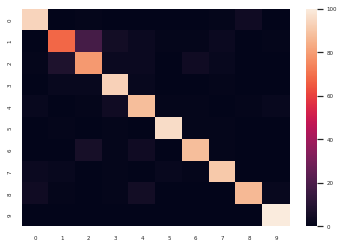

At step  10  and at epoch =  0  the loss is =  0.009012013673782349  and accuracy is =  0.2672857142857143
At step  10  and at epoch =  1  the loss is =  0.007767578586935997  and accuracy is =  0.2641428571428571
At step  10  and at epoch =  2  the loss is =  0.007912812754511833  and accuracy is =  0.26885714285714285
At step  10  and at epoch =  3  the loss is =  0.008681327104568481  and accuracy is =  0.2674285714285714
At step  10  and at epoch =  4  the loss is =  0.006476938724517822  and accuracy is =  0.2694285714285714
At step  10  and at epoch =  5  the loss is =  0.009020507335662842  and accuracy is =  0.2671428571428571
At step  10  and at epoch =  6  the loss is =  0.008152264170348644  and accuracy is =  0.2671428571428571
At step  10  and at epoch =  7  the loss is =  0.008294938132166862  and accuracy is =  0.2682857142857143
At step  10  and at epoch =  8  the loss is =  0.00825546309351921  and accuracy is =  0.2672857142857143
At step  10  and at epoch =  9  the l

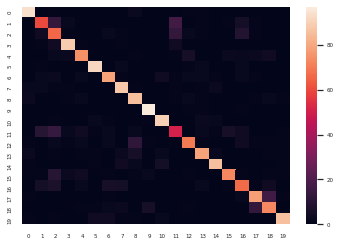

At step  20  and at epoch =  0  the loss is =  0.009169922210276127  and accuracy is =  0.23485714285714285
At step  20  and at epoch =  1  the loss is =  0.007557244971394539  and accuracy is =  0.23185714285714284
At step  20  and at epoch =  2  the loss is =  0.008869901299476624  and accuracy is =  0.23842857142857143
At step  20  and at epoch =  3  the loss is =  0.007933096960186958  and accuracy is =  0.23885714285714285
At step  20  and at epoch =  4  the loss is =  0.007457475643604994  and accuracy is =  0.2362857142857143
At step  20  and at epoch =  5  the loss is =  0.007431325037032366  and accuracy is =  0.241
At step  20  and at epoch =  6  the loss is =  0.008284416049718857  and accuracy is =  0.24085714285714285
At step  20  and at epoch =  7  the loss is =  0.007821218110620975  and accuracy is =  0.23942857142857144
At step  20  and at epoch =  8  the loss is =  0.0076410346664488316  and accuracy is =  0.24271428571428572
At step  20  and at epoch =  9  the loss i

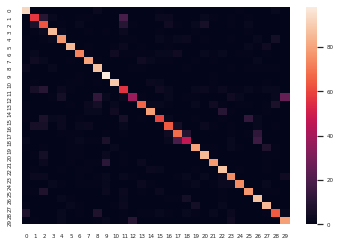

At step  30  and at epoch =  0  the loss is =  0.008751541376113892  and accuracy is =  0.22924393723252495
At step  30  and at epoch =  1  the loss is =  0.008776344358921051  and accuracy is =  0.22881597717546362
At step  30  and at epoch =  2  the loss is =  0.0075545539148151875  and accuracy is =  0.2348074179743224
At step  30  and at epoch =  3  the loss is =  0.007802905514836311  and accuracy is =  0.2332382310984308
At step  30  and at epoch =  4  the loss is =  0.008276809006929398  and accuracy is =  0.23651925820256775
At step  30  and at epoch =  5  the loss is =  0.008305895142257214  and accuracy is =  0.2355206847360913
At step  30  and at epoch =  6  the loss is =  0.0087362015619874  and accuracy is =  0.2390870185449358
At step  30  and at epoch =  7  the loss is =  0.0077522131614387035  and accuracy is =  0.23751783166904422
At step  30  and at epoch =  8  the loss is =  0.00789563823491335  and accuracy is =  0.2346647646219686
At step  30  and at epoch =  9  th

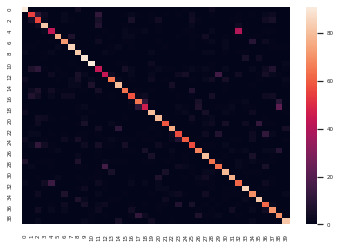

At step  40  and at epoch =  0  the loss is =  0.00760551868006587  and accuracy is =  0.229
At step  40  and at epoch =  1  the loss is =  0.007578874006867409  and accuracy is =  0.2267142857142857
At step  40  and at epoch =  2  the loss is =  0.007248046342283487  and accuracy is =  0.22785714285714287
At step  40  and at epoch =  3  the loss is =  0.00841735489666462  and accuracy is =  0.23042857142857143
At step  40  and at epoch =  4  the loss is =  0.007535957265645266  and accuracy is =  0.22885714285714287
At step  40  and at epoch =  5  the loss is =  0.007935467176139355  and accuracy is =  0.2307142857142857
At step  40  and at epoch =  6  the loss is =  0.007948593236505985  and accuracy is =  0.2332857142857143
At step  40  and at epoch =  7  the loss is =  0.008135602809488773  and accuracy is =  0.2337142857142857
At step  40  and at epoch =  8  the loss is =  0.00760998297482729  and accuracy is =  0.2347142857142857
At step  40  and at epoch =  9  the loss is =  0.0

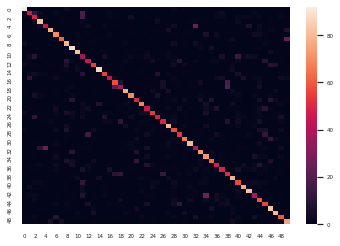

At step  50  and at epoch =  0  the loss is =  0.00847839005291462  and accuracy is =  0.21757142857142858
At step  50  and at epoch =  1  the loss is =  0.008047224953770638  and accuracy is =  0.213
At step  50  and at epoch =  2  the loss is =  0.007967834360897541  and accuracy is =  0.22285714285714286
At step  50  and at epoch =  3  the loss is =  0.008106455206871033  and accuracy is =  0.22128571428571428
At step  50  and at epoch =  4  the loss is =  0.008242974989116192  and accuracy is =  0.21942857142857142
At step  50  and at epoch =  5  the loss is =  0.006928679067641497  and accuracy is =  0.22171428571428572
At step  50  and at epoch =  6  the loss is =  0.007598319556564093  and accuracy is =  0.21928571428571428
At step  50  and at epoch =  7  the loss is =  0.008238810114562511  and accuracy is =  0.22085714285714286
At step  50  and at epoch =  8  the loss is =  0.007054260466247797  and accuracy is =  0.22357142857142856
At step  50  and at epoch =  9  the loss is

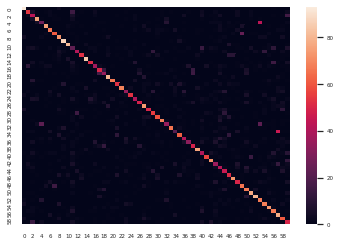

At step  60  and at epoch =  0  the loss is =  0.008568845689296722  and accuracy is =  0.2004297994269341
At step  60  and at epoch =  1  the loss is =  0.008814371190965176  and accuracy is =  0.20458452722063036
At step  60  and at epoch =  2  the loss is =  0.00988850835710764  and accuracy is =  0.20630372492836677
At step  60  and at epoch =  3  the loss is =  0.007057589013129473  and accuracy is =  0.21074498567335243
At step  60  and at epoch =  4  the loss is =  0.009267882443964481  and accuracy is =  0.20759312320916906
At step  60  and at epoch =  5  the loss is =  0.00865872297435999  and accuracy is =  0.21232091690544413
At step  60  and at epoch =  6  the loss is =  0.008289649151265621  and accuracy is =  0.21232091690544413
At step  60  and at epoch =  7  the loss is =  0.007960179820656776  and accuracy is =  0.21203438395415472
At step  60  and at epoch =  8  the loss is =  0.006981970742344856  and accuracy is =  0.30544412607449856
At step  60  and at epoch =  9 

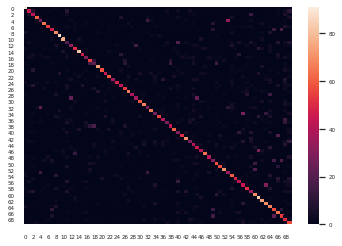

At step  70  and at epoch =  0  the loss is =  0.008085176348686218  and accuracy is =  0.19630156472261737
At step  70  and at epoch =  1  the loss is =  0.007628829684108496  and accuracy is =  0.19274537695590327
At step  70  and at epoch =  2  the loss is =  0.008708354085683823  and accuracy is =  0.1984352773826458
At step  70  and at epoch =  3  the loss is =  0.008103697560727596  and accuracy is =  0.1968705547652916
At step  70  and at epoch =  4  the loss is =  0.007647163234651089  and accuracy is =  0.20327169274537696
At step  70  and at epoch =  5  the loss is =  0.008181985467672348  and accuracy is =  0.20369843527738266
At step  70  and at epoch =  6  the loss is =  0.007807602174580097  and accuracy is =  0.20540540540540542
At step  70  and at epoch =  7  the loss is =  0.00666799396276474  and accuracy is =  0.29317211948790894
At step  70  and at epoch =  8  the loss is =  0.0062326304614543915  and accuracy is =  0.3588904694167852
At step  70  and at epoch =  9 

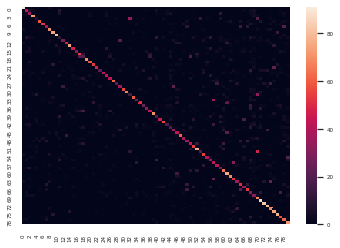

At step  80  and at epoch =  0  the loss is =  0.007933071814477444  and accuracy is =  0.19085714285714286
At step  80  and at epoch =  1  the loss is =  0.007132871076464653  and accuracy is =  0.192
At step  80  and at epoch =  2  the loss is =  0.008215652778744698  and accuracy is =  0.19342857142857142
At step  80  and at epoch =  3  the loss is =  0.007510242518037558  and accuracy is =  0.19342857142857142
At step  80  and at epoch =  4  the loss is =  0.007325342390686274  and accuracy is =  0.19342857142857142
At step  80  and at epoch =  5  the loss is =  0.007724027615040541  and accuracy is =  0.19414285714285714
At step  80  and at epoch =  6  the loss is =  0.006819114089012146  and accuracy is =  0.20785714285714285
At step  80  and at epoch =  7  the loss is =  0.007373272441327572  and accuracy is =  0.29942857142857143
At step  80  and at epoch =  8  the loss is =  0.006117728538811207  and accuracy is =  0.40685714285714286
At step  80  and at epoch =  9  the loss i

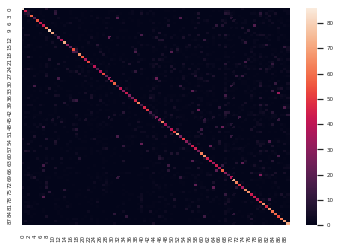

At step  90  and at epoch =  0  the loss is =  0.007578982971608639  and accuracy is =  0.17349570200573067
At step  90  and at epoch =  1  the loss is =  0.008136252872645855  and accuracy is =  0.1693409742120344
At step  90  and at epoch =  2  the loss is =  0.007743365131318569  and accuracy is =  0.17521489971346704
At step  90  and at epoch =  3  the loss is =  0.00820177048444748  and accuracy is =  0.17636103151862464
At step  90  and at epoch =  4  the loss is =  0.007353282067924738  and accuracy is =  0.17593123209169054
At step  90  and at epoch =  5  the loss is =  0.007671325467526913  and accuracy is =  0.1806590257879656
At step  90  and at epoch =  6  the loss is =  0.006482697557657957  and accuracy is =  0.28653295128939826
At step  90  and at epoch =  7  the loss is =  0.005795971490442753  and accuracy is =  0.40959885386819483
At step  90  and at epoch =  8  the loss is =  0.004399382043629885  and accuracy is =  0.51189111747851
At step  90  and at epoch =  9  th

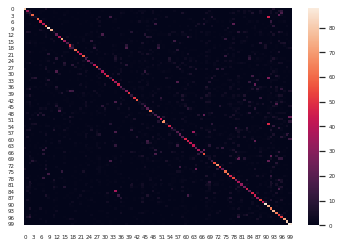

In [10]:
for task in range(0, 100, params.TASK_SIZE):
  train_indexes = trainDS.__getIndexesGroups__(task)
  test_indexes = test_indexes + testDS.__getIndexesGroups__(task)

  train_dataset = Subset(trainDS, train_indexes, transform = train_transformer)
  test_dataset = Subset(testDS, test_indexes, transform = test_transformer)

  train_loader = DataLoader( train_dataset, num_workers=params.NUM_WORKERS, batch_size=params.BATCH_SIZE, shuffle=True)
  test_loader = DataLoader( test_dataset, num_workers=params.NUM_WORKERS, batch_size=params.BATCH_SIZE , shuffle=True )
  
  ICaRL, exemplars = ICaRLModel.incrementalTrain(task, trainDS, ICaRL, exemplars, train_transformer)

  col = []
  for i,x in enumerate( train_splits[ :int(task/10) + 1]) : 
    v = np.array(x)
    col = np.concatenate( (col,v), axis = None)
    col = col.astype(int)
  mean = None
  total = 0.0
  running_corrects = 0.0
  for img, lbl, _ in train_loader:
      img = img.float().to(params.DEVICE)
      preds, mean = ICaRLModel.classify(img, exemplars, ICaRL, task, trainDS, mean)
      preds = preds.to(params.DEVICE)
      labels = utils.mapFunction(lbl, col).to(params.DEVICE)

      total += len(lbl)
      running_corrects += torch.sum(preds == labels.data).data.item()

  accuracy = float(running_corrects/total)
  print(f'task: {task}', f'train accuracy = {accuracy}')
  accs.append(accuracy)

  total = 0.0
  running_corrects = 0.0
  tot_preds = []
  tot_lab = []
  for img, lbl, _ in test_loader:
      img = img.float().to(params.DEVICE)
      preds, _ = ICaRLModel.classify(img, exemplars, ICaRL, task, trainDS, mean)
      preds = preds.to(params.DEVICE)
      labels = utils.mapFunction(lbl, col).to(params.DEVICE)

      tot_preds = np.concatenate( ( tot_preds, preds.data.cpu().numpy() ) )
      tot_lab = np.concatenate( (tot_lab, labels.data.cpu().numpy()  ) )

      total += len(lbl)
      running_corrects += torch.sum(preds == labels.data).data.item()

  accuracy = float(running_corrects/total)
  print(f'task: {task}', f'test accuracy = {accuracy}')
  cf = confusion_matrix(tot_lab, tot_preds)
  df_cm = pd.DataFrame(cf, range(task + params.TASK_SIZE), range(task + params.TASK_SIZE))
  sn.set(font_scale = .5) # for label size
  sn.heatmap(df_cm, annot=False)
  plt.show()